# Employee Sentiment Analysis and Engagement Evaluation

This notebook performs a comprehensive sentiment analysis of employee emails to:
- Classify messages as Positive, Negative, or Neutral
- Analyze sentiment trends and patterns
- Calculate monthly sentiment scores per employee
- Rank employees by sentiment
- Identify flight risks (employees at risk of leaving)
- Develop predictive models for sentiment trends

**Dataset**: test.xlsx (employee emails with timestamps and metadata)
**NLP Approach**: VADER (Valence Aware Dictionary and sEntiment Reasoner) for sentiment analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings('ignore')

# Set display options for better DataFrame visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All required libraries successfully imported")
print("Environment configured and ready for analysis")

✓ All required libraries successfully imported
✓ Environment configured and ready for analysis


## Task 1: Sentiment Labeling

**Objective**: Label each employee message with one of three sentiment categories: Positive, Negative, or Neutral.

**Approach**: Using VADER (Valence Aware Dictionary and sEntiment Reasoner), a lexicon-based sentiment analysis tool specifically designed for social media and short text. VADER provides:
- A compound score ranging from -1 (most negative) to +1 (most positive)
- Thresholds: Positive (≥0.05), Negative (≤-0.05), Neutral (between -0.05 and 0.05)

This approach is reproducible, rule-based, and requires no model training.

In [2]:
import pandas as pd

# Load data from Excel file
df = pd.read_excel("test.xlsx")

# Display initial data structure
print("Dataset Overview:")
print(f"  - Shape: {df.shape}")
print(f"  - Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Rename columns for consistency (mapping actual columns to standardized names)
df = df.rename(columns={
    "from": "employee_id",
    "body": "message_text",
    "date": "timestamp",
    "Subject": "subject"
})

# Convert timestamp to datetime and handle missing values
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["message_text"] = df["message_text"].astype(str).fillna("")

print("\n Data loaded and preprocessed successfully")

Dataset Overview:
  - Shape: (2191, 4)
  - Columns: ['Subject', 'body', 'date', 'from']

First few rows:
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [3]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define function to label sentiment based on compound score
def label_sentiment(text):
    """
    Classify text sentiment using VADER analyzer.
    
    Returns:
        - "Positive": compound score >= 0.05
        - "Negative": compound score <= -0.05
        - "Neutral": -0.05 < compound score < 0.05
    """
    # Handle empty or non-string messages
    if not text.strip():
        return "Neutral"
    
    # Get compound score from VADER
    score = analyzer.polarity_scores(text)["compound"]
    
    # Apply thresholds to classify sentiment
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment labeling to each message
df["sentiment_label"] = df["message_text"].apply(label_sentiment)

# Map sentiment labels to numeric scores for aggregation
df["sentiment_score"] = df["sentiment_label"].map({"Positive": 1, "Neutral": 0, "Negative": -1})

# Create additional feature: message length
df["msg_len"] = df["message_text"].str.len()

# Extract month from timestamp for temporal analysis
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

print("✓ Sentiment labeling completed")
print(f"\nSentiment Distribution:")
print(df["sentiment_label"].value_counts())
print(f"\nDataset with sentiment labels (first 10 rows):")
print(df[["employee_id", "timestamp", "sentiment_label", "sentiment_score", "month"]].head(10))

✓ Sentiment labeling completed

Sentiment Distribution:
sentiment_label
Positive    1525
Neutral      508
Negative     158
Name: count, dtype: int64

Dataset with sentiment labels (first 10 rows):
                employee_id  timestamp sentiment_label  sentiment_score  \
0      sally.beck@enron.com 2010-05-10        Positive                1   
1       eric.bass@enron.com 2010-07-29        Positive                1   
2      sally.beck@enron.com 2011-07-25         Neutral                0   
3   johnny.palmer@enron.com 2010-03-25         Neutral                0   
4   lydia.delgado@enron.com 2011-05-21        Positive                1   
5       eric.bass@enron.com 2011-10-23        Positive                1   
6   kayne.coulter@enron.com 2010-04-05         Neutral                0   
7  patti.thompson@enron.com 2010-04-21        Positive                1   
8      sally.beck@enron.com 2010-02-07        Positive                1   
9   kayne.coulter@enron.com 2010-02-06        Negativ

In [4]:
# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Define function to label sentiment based on compound score
def label_sentiment(text):
    """
    Classify text sentiment using VADER analyzer.
    
    Returns:
        - "Positive": compound score >= 0.05
        - "Negative": compound score <= -0.05
        - "Neutral": -0.05 < compound score < 0.05
    """
    # Handle empty or non-string messages
    if not text.strip():
        return "Neutral"
    
    # Get compound score from VADER
    score = analyzer.polarity_scores(text)["compound"]
    
    # Apply thresholds to classify sentiment
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Apply sentiment labeling to each message
df["sentiment_label"] = df["message_text"].apply(label_sentiment)

# Map sentiment labels to numeric scores for aggregation
df["sentiment_score"] = df["sentiment_label"].map({"Positive": 1, "Neutral": 0, "Negative": -1})

# Create additional feature: message length
df["msg_len"] = df["message_text"].str.len()

# Extract month from timestamp for temporal analysis
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

print("✓ Sentiment labeling completed")
print(f"\nSentiment Distribution:")
print(df["sentiment_label"].value_counts())
print(f"\nDataset with sentiment labels (first 10 rows):")
print(df[["employee_id", "timestamp", "sentiment_label", "sentiment_score", "month"]].head(10))

✓ Sentiment labeling completed

Sentiment Distribution:
sentiment_label
Positive    1525
Neutral      508
Negative     158
Name: count, dtype: int64

Dataset with sentiment labels (first 10 rows):
                employee_id  timestamp sentiment_label  sentiment_score  \
0      sally.beck@enron.com 2010-05-10        Positive                1   
1       eric.bass@enron.com 2010-07-29        Positive                1   
2      sally.beck@enron.com 2011-07-25         Neutral                0   
3   johnny.palmer@enron.com 2010-03-25         Neutral                0   
4   lydia.delgado@enron.com 2011-05-21        Positive                1   
5       eric.bass@enron.com 2011-10-23        Positive                1   
6   kayne.coulter@enron.com 2010-04-05         Neutral                0   
7  patti.thompson@enron.com 2010-04-21        Positive                1   
8      sally.beck@enron.com 2010-02-07        Positive                1   
9   kayne.coulter@enron.com 2010-02-06        Negativ

## Task 2: Exploratory Data Analysis (EDA)

**Objective**: Understand the structure, distribution, and trends in the dataset through thorough exploration.

**Analysis includes**:
- Data structure examination (records, data types, missing values)
- Distribution of sentiment labels
- Temporal trends
- Pattern identification and anomalies

EXPLORATORY DATA ANALYSIS (EDA)

1. DATA STRUCTURE EXAMINATION
--------------------------------------------------------------------------------
Total Records: 2191
Total Unique Employees: 10
Date Range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00

Data Types:
subject                    object
message_text               object
timestamp          datetime64[ns]
employee_id                object
sentiment_label            object
sentiment_score             int64
msg_len                     int64
month                      object
dtype: object

Missing Values:
subject            0
message_text       0
timestamp          0
employee_id        0
sentiment_label    0
sentiment_score    0
msg_len            0
month              0
dtype: int64

2. SENTIMENT DISTRIBUTION
--------------------------------------------------------------------------------
Positive    :   1525 ( 69.60%)
Neutral     :    508 ( 23.19%)
Negative    :    158 (  7.21%)


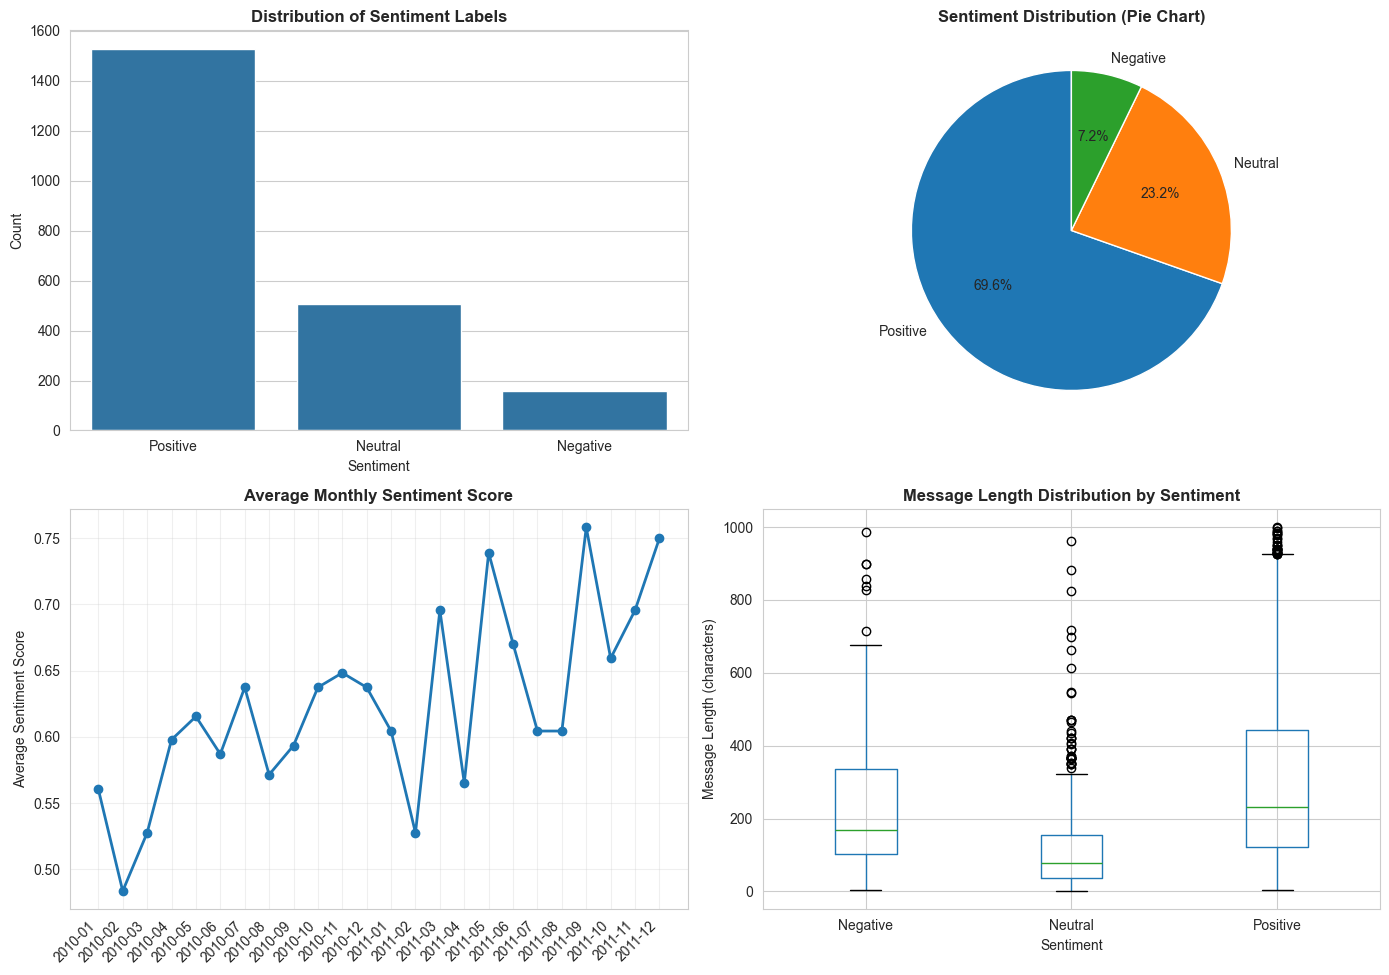


4. MONTHLY SENTIMENT STATISTICS
--------------------------------------------------------------------------------
         Total Score  Avg Score  Message Count  Positive Count
month                                                         
2010-01           51   0.560440             91              57
2010-02           44   0.483516             91              55
2010-03           48   0.527473             91              58
2010-04           55   0.597826             92              63
2010-05           56   0.615385             91              62
2010-06           54   0.586957             92              62
2010-07           58   0.637363             91              65
2010-08           52   0.571429             91              61
2010-09           54   0.593407             91              61
2010-10           58   0.637363             91              62
2010-11           59   0.648352             91              67
2010-12           58   0.637363             91              65
2011

In [ ]:
print("=" * 80)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("=" * 80)

# 1. Data structure examination
print("\n1. DATA STRUCTURE EXAMINATION")
print("-" * 80)
print(f"Total Records: {len(df)}")
print(f"Total Unique Employees: {df['employee_id'].nunique()}")
print(f"Date Range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")

# 2. Sentiment distribution
print("\n2. SENTIMENT DISTRIBUTION")
print("-" * 80)
sentiment_counts = df["sentiment_label"].value_counts()
sentiment_pct = (sentiment_counts / len(df) * 100).round(2)
for sentiment in ["Positive", "Neutral", "Negative"]:
    if sentiment in sentiment_counts.index:
        print(f"{sentiment:12s}: {sentiment_counts[sentiment]:6d} ({sentiment_pct[sentiment]:6.2f}%)")

# 3. Distribution by department (if available)
if "department" in df.columns:
    print("\n3. SENTIMENT DISTRIBUTION BY DEPARTMENT")
    print("-" * 80)
    dept_sentiment = pd.crosstab(df["department"], df["sentiment_label"])
    print(dept_sentiment)

# 4. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 4.1 Sentiment label distribution
sns.countplot(data=df, x="sentiment_label", ax=axes[0, 0], order=["Positive", "Neutral", "Negative"])
axes[0, 0].set_title("Distribution of Sentiment Labels", fontsize=12, fontweight="bold")
axes[0, 0].set_xlabel("Sentiment")
axes[0, 0].set_ylabel("Count")

# 4.2 Pie chart for sentiment distribution
sentiment_dist = df["sentiment_label"].value_counts()
axes[0, 1].pie(sentiment_dist.values, labels=sentiment_dist.index, autopct="%1.1f%%", startangle=90)
axes[0, 1].set_title("Sentiment Distribution (Pie Chart)", fontsize=12, fontweight="bold")

# 4.3 Monthly sentiment trend
monthly_sentiment = df.groupby("month")["sentiment_score"].mean()
axes[1, 0].plot(range(len(monthly_sentiment)), monthly_sentiment.values, marker="o", linewidth=2, markersize=6)
axes[1, 0].set_xticks(range(len(monthly_sentiment)))
axes[1, 0].set_xticklabels(monthly_sentiment.index, rotation=45, ha="right")
axes[1, 0].set_title("Average Monthly Sentiment Score", fontsize=12, fontweight="bold")
axes[1, 0].set_ylabel("Average Sentiment Score")
axes[1, 0].grid(True, alpha=0.3)

# 4.4 Message length distribution by sentiment
df.boxplot(column="msg_len", by="sentiment_label", ax=axes[1, 1])
axes[1, 1].set_title("Message Length Distribution by Sentiment", fontsize=12, fontweight="bold")
axes[1, 1].set_xlabel("Sentiment")
axes[1, 1].set_ylabel("Message Length (characters)")
plt.suptitle("")  # Remove the automatic title

plt.tight_layout()
plt.show()

# 5. Monthly sentiment scores
print("\n4. MONTHLY SENTIMENT STATISTICS")
print("-" * 80)
monthly_stats = df.groupby("month").agg({
    "sentiment_score": ["sum", "mean", "count"],
    "sentiment_label": lambda x: (x == "Positive").sum()
})
monthly_stats.columns = ["Total Score", "Avg Score", "Message Count", "Positive Count"]
print(monthly_stats)

print("\n Exploratory Data Analysis completed")

## Task 3: Employee Score Calculation

**Objective**: Compute a monthly sentiment score for each employee.

**Scoring System**:
- Positive Message: +1
- Neutral Message: 0
- Negative Message: -1

**Aggregation**: Scores are summed on a monthly basis for each employee, resetting at the beginning of each new month.

In [ ]:
print("=" * 80)
print("EMPLOYEE SCORE CALCULATION")
print("=" * 80)

# Group messages by employee and month, then sum sentiment scores
monthly_scores = (
    df.groupby(["employee_id", "month"])["sentiment_score"]
      .sum()
      .reset_index(name="monthly_sentiment_score")
)

# Add message count per employee per month
monthly_counts = (
    df.groupby(["employee_id", "month"])["sentiment_label"]
      .value_counts()
      .unstack(fill_value=0)
      .reset_index()
)
monthly_scores = monthly_scores.merge(
    monthly_counts[["employee_id", "month", "Positive", "Neutral", "Negative"]] 
    if all(col in monthly_counts.columns for col in ["Positive", "Neutral", "Negative"])
    else monthly_counts[["employee_id", "month"]],
    on=["employee_id", "month"],
    how="left"
)

print("\n Monthly Employee Sentiment Scores (first 20 rows):")
print(monthly_scores.head(20))

print(f"\n Calculated sentiment scores for {monthly_scores['employee_id'].nunique()} employees across {monthly_scores['month'].nunique()} months")

# Summary statistics
print("\nSummary Statistics of Monthly Sentiment Scores:")
print(monthly_scores["monthly_sentiment_score"].describe().round(2))

EMPLOYEE SCORE CALCULATION

Monthly Employee Sentiment Scores (first 20 rows):
                    employee_id    month  monthly_sentiment_score  Positive  \
0   bobette.riner@ipgdirect.com  2010-01                        1         1   
1   bobette.riner@ipgdirect.com  2010-02                        7         8   
2   bobette.riner@ipgdirect.com  2010-03                        6         7   
3   bobette.riner@ipgdirect.com  2010-04                        4         4   
4   bobette.riner@ipgdirect.com  2010-05                        2         2   
5   bobette.riner@ipgdirect.com  2010-06                        2         2   
6   bobette.riner@ipgdirect.com  2010-07                        8         9   
7   bobette.riner@ipgdirect.com  2010-08                        4         6   
8   bobette.riner@ipgdirect.com  2010-09                        5         8   
9   bobette.riner@ipgdirect.com  2010-10                        6         6   
10  bobette.riner@ipgdirect.com  2010-11            

## Task 4: Employee Ranking

**Objective**: Generate ranked lists of employees based on monthly sentiment scores.

**Outputs**:
1. **Top Three Positive Employees**: Highest sentiment scores per month
2. **Top Three Negative Employees**: Lowest (most negative) sentiment scores per month

**Sorting**: By sentiment score first, then alphabetically by employee ID for tie-breaking.

EMPLOYEE RANKING

TOP 3 POSITIVE EMPLOYEES (BY MONTH):
--------------------------------------------------------------------------------

2011-10:
  1. lydia.delgado@enron.com: Score = +12
  2. john.arnold@enron.com: Score = +10
  3. don.baughman@enron.com: Score = +9

2011-11:
  1. kayne.coulter@enron.com: Score = +15
  2. john.arnold@enron.com: Score = +10
  3. bobette.riner@ipgdirect.com: Score = +9

2011-12:
  1. eric.bass@enron.com: Score = +12
  2. patti.thompson@enron.com: Score = +12
  3. lydia.delgado@enron.com: Score = +11


TOP 3 NEGATIVE EMPLOYEES (BY MONTH):
--------------------------------------------------------------------------------

2011-10:
  1. bobette.riner@ipgdirect.com: Score = +0
  2. rhonda.denton@enron.com: Score = +0
  3. johnny.palmer@enron.com: Score = +2

2011-11:
  1. eric.bass@enron.com: Score = +1
  2. rhonda.denton@enron.com: Score = +2
  3. lydia.delgado@enron.com: Score = +4

2011-12:
  1. johnny.palmer@enron.com: Score = +2
  2. bobette.riner@ipgdir

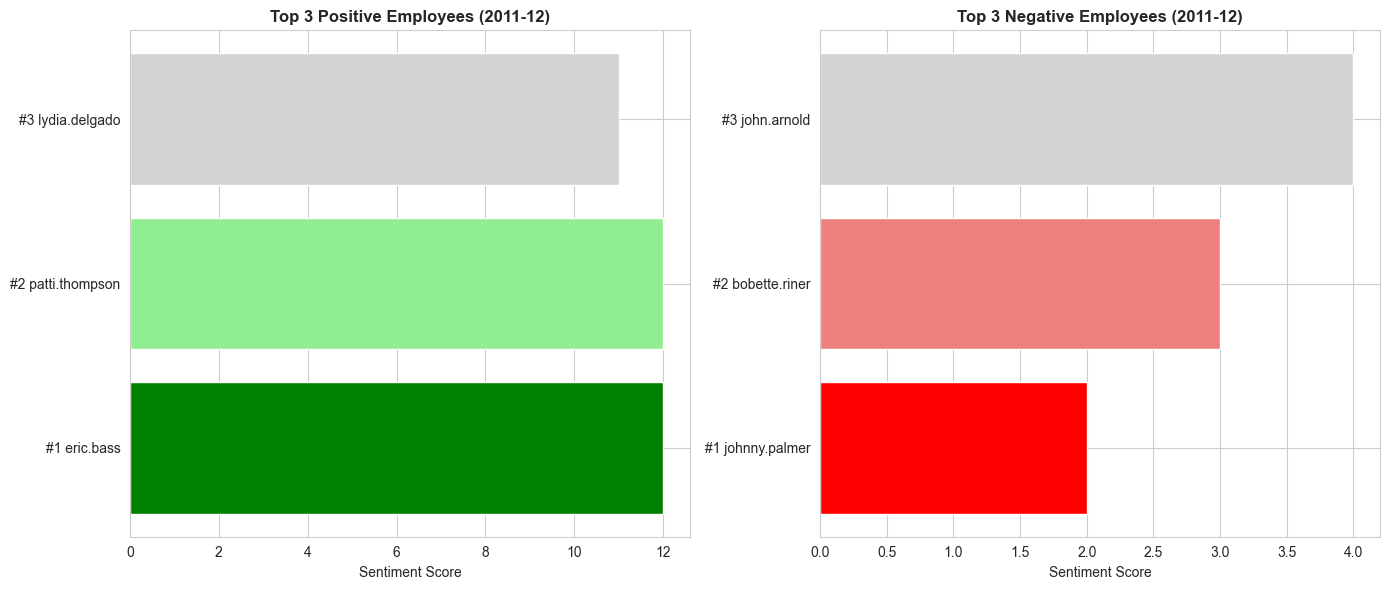


✓ Employee ranking completed


In [ ]:
print("=" * 80)
print("EMPLOYEE RANKING")
print("=" * 80)

# Define function to get top 3 employees by score
def top3(group, ascending):
    """Extract top 3 employees from a month group, sorted by score and employee_id"""
    return group.sort_values(
        ["monthly_sentiment_score", "employee_id"],
        ascending=[ascending, True]
    ).head(3)

# Get top 3 positive employees per month
rank_pos = monthly_scores.groupby("month", group_keys=False).apply(
    lambda g: top3(g, ascending=False)
).reset_index(drop=True)

# Get top 3 negative employees per month
rank_neg = monthly_scores.groupby("month", group_keys=False).apply(
    lambda g: top3(g, ascending=True)
).reset_index(drop=True)

# Display results
print("\nTOP 3 POSITIVE EMPLOYEES (BY MONTH):")
print("-" * 80)
for month in sorted(rank_pos["month"].unique())[-3:]:  # Show last 3 months
    month_data = rank_pos[rank_pos["month"] == month].reset_index(drop=True)
    print(f"\n{month}:")
    for idx, row in month_data.iterrows():
        print(f"  {idx+1}. {row['employee_id']}: Score = {row['monthly_sentiment_score']:+.0f}")

print("\n\nTOP 3 NEGATIVE EMPLOYEES (BY MONTH):")
print("-" * 80)
for month in sorted(rank_neg["month"].unique())[-3:]:  # Show last 3 months
    month_data = rank_neg[rank_neg["month"] == month].reset_index(drop=True)
    print(f"\n{month}:")
    for idx, row in month_data.iterrows():
        print(f"  {idx+1}. {row['employee_id']}: Score = {row['monthly_sentiment_score']:+.0f}")

# Visualization: Top/Bottom employees
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get latest month for visualization
latest_month = sorted(rank_pos["month"].unique())[-1]
pos_latest = rank_pos[rank_pos["month"] == latest_month].reset_index(drop=True)
neg_latest = rank_neg[rank_neg["month"] == latest_month].reset_index(drop=True)

# Positive rankings
if len(pos_latest) > 0:
    labels_pos = [f"#{i+1} {email.split('@')[0]}" for i, email in enumerate(pos_latest["employee_id"])]
    axes[0].barh(labels_pos, pos_latest["monthly_sentiment_score"], color=["green", "lightgreen", "lightgray"][:len(pos_latest)])
    axes[0].set_title(f"Top 3 Positive Employees ({latest_month})", fontsize=12, fontweight="bold")
    axes[0].set_xlabel("Sentiment Score")

# Negative rankings
if len(neg_latest) > 0:
    labels_neg = [f"#{i+1} {email.split('@')[0]}" for i, email in enumerate(neg_latest["employee_id"])]
    axes[1].barh(labels_neg, neg_latest["monthly_sentiment_score"], color=["red", "lightcoral", "lightgray"][:len(neg_latest)])
    axes[1].set_title(f"Top 3 Negative Employees ({latest_month})", fontsize=12, fontweight="bold")
    axes[1].set_xlabel("Sentiment Score")

plt.tight_layout()
plt.show()

print("\n Employee ranking completed")

## Task 5: Flight Risk Identification

**Objective**: Identify employees at risk of leaving based on negative message frequency.

**Approach**: Using a rolling 30-day window to detect patterns of increasing negativity that might indicate disengagement.

FLIGHT RISK IDENTIFICATION

Flight Risk Threshold: ≥4 negative messages in 30 days
Number of Flight Risk Employees: 6

Flight Risk Employees:
--------------------------------------------------------------------------------
  sally.beck@enron.com: 5 negative messages in 30-day window
  bobette.riner@ipgdirect.com: 4 negative messages in 30-day window
  don.baughman@enron.com: 4 negative messages in 30-day window
  john.arnold@enron.com: 4 negative messages in 30-day window
  johnny.palmer@enron.com: 4 negative messages in 30-day window
  kayne.coulter@enron.com: 4 negative messages in 30-day window


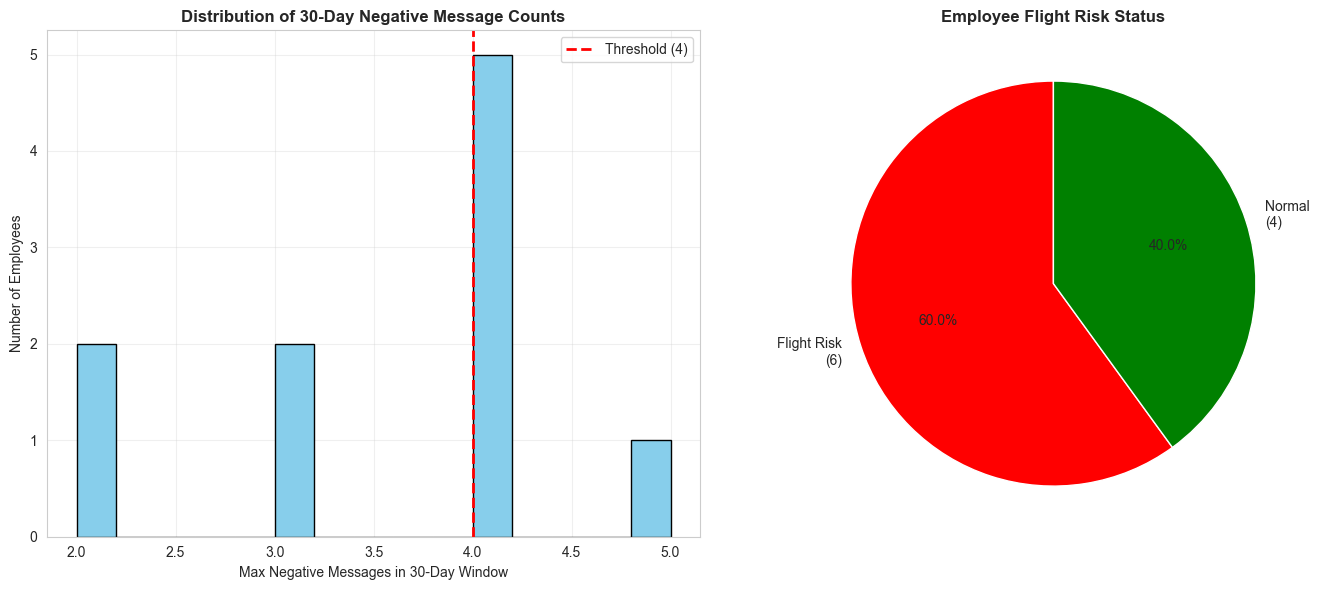


✓ Flight risk identification completed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load and preprocess data
df = pd.read_excel("test.xlsx")
df = df.rename(columns={"from": "employee_id", "body": "message_text", "date": "timestamp", "Subject": "subject"})
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["message_text"] = df["message_text"].astype(str).fillna("")

# Apply sentiment labeling
analyzer = SentimentIntensityAnalyzer()
def label_sentiment(text):
    if not text.strip():
        return "Neutral"
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["message_text"].apply(label_sentiment)
df["sentiment_score"] = df["sentiment_label"].map({"Positive": 1, "Neutral": 0, "Negative": -1})
df["msg_len"] = df["message_text"].str.len()
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

print("=" * 80)
print("FLIGHT RISK IDENTIFICATION")
print("=" * 80)

# Filter only negative messages
neg = df[df["sentiment_label"] == "Negative"].copy()

# Sort by employee and timestamp for rolling window
neg = neg.sort_values(["employee_id", "timestamp"])

# Define rolling 30-day count function
def rolling_30d(group):
    """Calculate rolling 30-day count of negative messages per employee"""
    # Set timestamp as index for time-based rolling
    group = group.set_index("timestamp").sort_index()
    # Count negative messages in 30-day rolling window
    group["neg_30d_count"] = group["sentiment_label"].rolling("30D").count()
    return group.reset_index()

# Apply rolling count per employee
neg_roll = neg.groupby("employee_id", group_keys=False).apply(rolling_30d)

# Get max rolling count per employee
flight_risk = (
    neg_roll.groupby("employee_id")["neg_30d_count"].max().reset_index()
    .rename(columns={"neg_30d_count": "max_30d_negative_count"})
)

# Flag employees with ≥4 negative messages in any 30-day window
flight_risk_threshold = 4
flight_risk["is_flight_risk"] = flight_risk["max_30d_negative_count"] >= flight_risk_threshold
flight_risk_ids = flight_risk[flight_risk["is_flight_risk"]]["employee_id"].tolist()

# Display results
print(f"\nFlight Risk Threshold: ≥{flight_risk_threshold} negative messages in 30 days")
print(f"Number of Flight Risk Employees: {len(flight_risk_ids)}")
print(f"\nFlight Risk Employees:")
print("-" * 80)

if flight_risk_ids:
    risk_details = flight_risk[flight_risk["is_flight_risk"]].sort_values("max_30d_negative_count", ascending=False)
    for idx, row in risk_details.iterrows():
        print(f"  {row['employee_id']}: {row['max_30d_negative_count']:.0f} negative messages in 30-day window")
else:
    print("  No employees identified as flight risk")

# Visualization: Flight risk distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histogram of max 30-day counts
axes[0].hist(flight_risk["max_30d_negative_count"].dropna(), bins=15, color="skyblue", edgecolor="black")
axes[0].axvline(x=flight_risk_threshold, color="red", linestyle="--", linewidth=2, label=f"Threshold ({flight_risk_threshold})")
axes[0].set_xlabel("Max Negative Messages in 30-Day Window")
axes[0].set_ylabel("Number of Employees")
axes[0].set_title("Distribution of 30-Day Negative Message Counts", fontsize=12, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Pie chart: Flight risk status
risk_status = flight_risk["is_flight_risk"].value_counts()
labels = [f"Flight Risk\n({risk_status.get(True, 0)})", f"Normal\n({risk_status.get(False, 0)})"]
colors = ["red", "green"]
axes[1].pie(
    [risk_status.get(True, 0), risk_status.get(False, 0)],
    labels=labels,
    colors=colors,
    autopct="%1.1f%%",
    startangle=90
)
axes[1].set_title("Employee Flight Risk Status", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

print("\n Flight risk identification completed")

## Task 6: Predictive Modeling

**Objective**: Develop a linear regression model to predict employee sentiment scores.

**Independent Variables (Features)**:
- `message_count`: Total messages sent in the month
- `avg_msg_len`: Average message length
- `std_msg_len`: Standard deviation of message length
- `pos_ratio`: Proportion of positive messages
- `neg_ratio`: Proportion of negative messages

**Target Variable**: `monthly_sentiment_score` (sum of sentiment scores per month)

**Model Evaluation**: R² score, RMSE, and feature coefficient analysis

PREDICTIVE MODELING - LINEAR REGRESSION

Feature Engineering Summary:
  - Total samples: 240
  - Features used: message_count, avg_msg_len, std_msg_len, pos_ratio, neg_ratio
  - Target variable: monthly_sentiment_score

Feature Statistics:
       message_count  avg_msg_len  std_msg_len  pos_ratio  neg_ratio
count        240.000      240.000      240.000    240.000    240.000
mean           9.129      254.753      189.514      0.699      0.070
std            5.728      104.000      100.062      0.219      0.133
min            1.000        3.000        0.000      0.000      0.000
25%            4.750      196.643      126.665      0.614      0.000
50%            9.000      244.385      203.957      0.706      0.000
75%           12.000      299.089      261.835      0.833      0.111
max           27.000      725.000      384.378      1.000      1.000

Data Split:
  - Training set: 192 samples (80.0%)
  - Testing set:  48 samples (20.0%)

MODEL PERFORMANCE METRICS

Training Set:
  - R² Sc

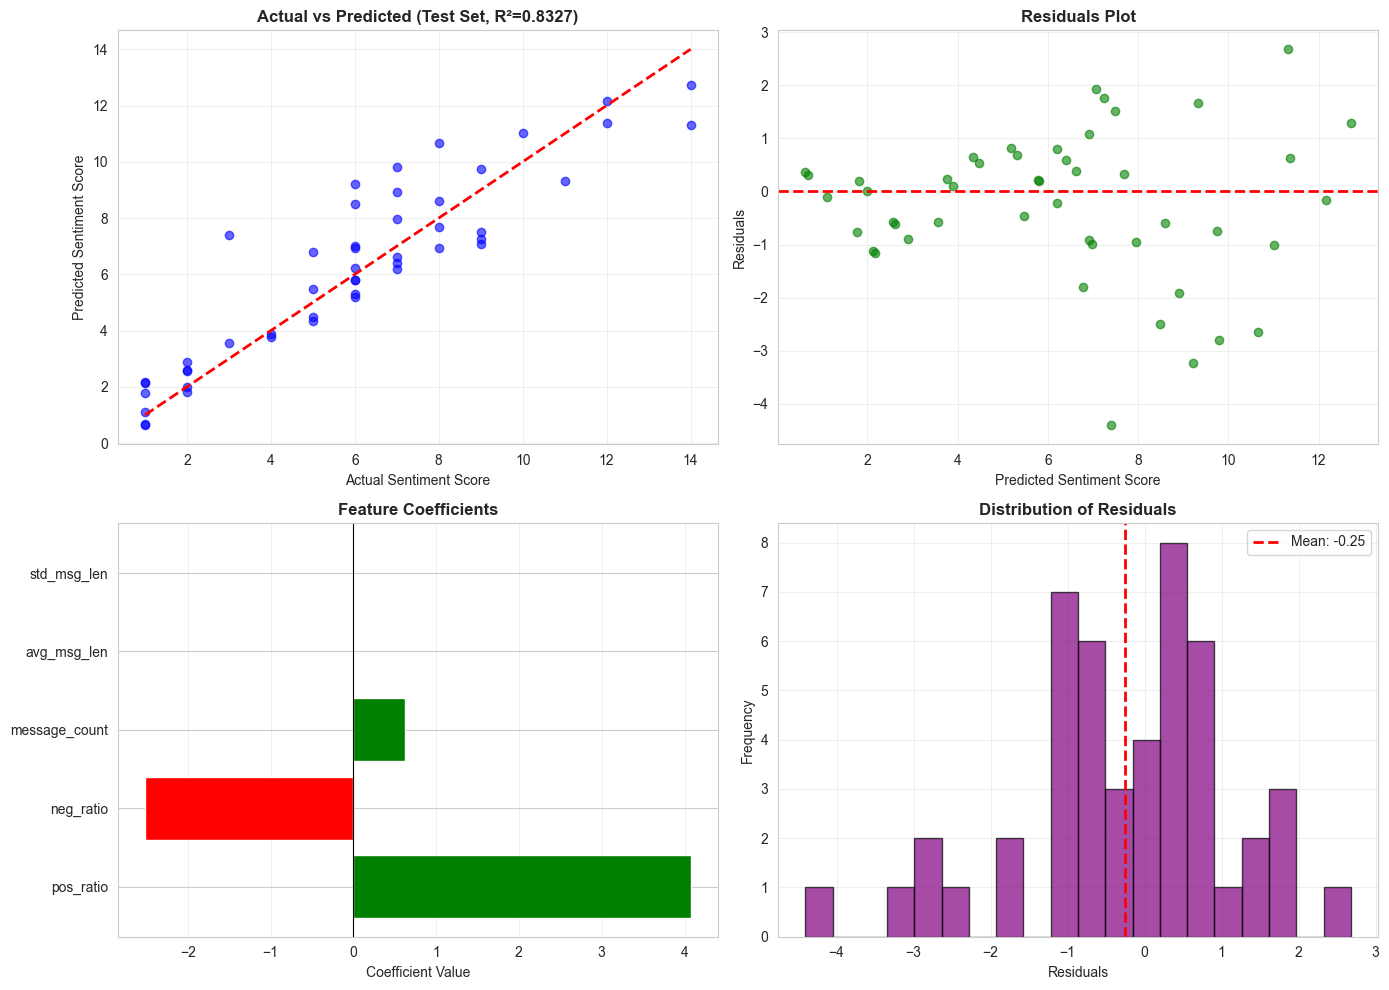


✓ Predictive modeling completed


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load and preprocess data
df = pd.read_excel("test.xlsx")
df = df.rename(columns={"from": "employee_id", "body": "message_text", "date": "timestamp", "Subject": "subject"})
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["message_text"] = df["message_text"].astype(str).fillna("")

# Apply sentiment labeling
analyzer = SentimentIntensityAnalyzer()
def label_sentiment(text):
    if not text.strip():
        return "Neutral"
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df["sentiment_label"] = df["message_text"].apply(label_sentiment)
df["sentiment_score"] = df["sentiment_label"].map({"Positive": 1, "Neutral": 0, "Negative": -1})
df["msg_len"] = df["message_text"].str.len()
df["month"] = df["timestamp"].dt.to_period("M").astype(str)

# Calculate monthly scores (needed for merge)
monthly_scores = (
    df.groupby(["employee_id", "month"])["sentiment_score"]
      .sum()
      .reset_index(name="monthly_sentiment_score")
)

print("=" * 80)
print("PREDICTIVE MODELING - LINEAR REGRESSION")
print("=" * 80)

# Aggregate features per employee-month
features = df.groupby(["employee_id", "month"]).agg(
    message_count = ("message_text", "count"),
    avg_msg_len   = ("msg_len", "mean"),
    std_msg_len   = ("msg_len", "std"),
    pos_count     = ("sentiment_label", lambda x: (x=="Positive").sum()),
    neg_count     = ("sentiment_label", lambda x: (x=="Negative").sum()),
).reset_index()

# Calculate sentiment ratios
features["pos_ratio"] = features["pos_count"] / features["message_count"]
features["neg_ratio"] = features["neg_count"] / features["message_count"]

# Merge with target sentiment scores
data_model = features.merge(monthly_scores, on=["employee_id", "month"], how="left")

print("\nFeature Engineering Summary:")
print(f"  - Total samples: {len(data_model)}")
print(f"  - Features used: message_count, avg_msg_len, std_msg_len, pos_ratio, neg_ratio")
print(f"  - Target variable: monthly_sentiment_score")

# Define feature matrix and target variable
X = data_model[["message_count", "avg_msg_len", "std_msg_len", "pos_ratio", "neg_ratio"]].fillna(0)
y = data_model["monthly_sentiment_score"]

print(f"\nFeature Statistics:")
print(X.describe().round(3))

# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nData Split:")
print(f"  - Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Testing set:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Fit linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on both sets
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Calculate evaluation metrics
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print("\n" + "=" * 80)
print("MODEL PERFORMANCE METRICS")
print("=" * 80)
print(f"\nTraining Set:")
print(f"  - R² Score:  {r2_train:.4f}")
print(f"  - RMSE:      {rmse_train:.4f}")

print(f"\nTesting Set:")
print(f"  - R² Score:  {r2_test:.4f}")
print(f"  - RMSE:      {rmse_test:.4f}")
print(f"  - MAE:       {mae_test:.4f}")

# Extract and interpret feature coefficients
coeffs = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": lr.coef_,
    "Abs_Coefficient": np.abs(lr.coef_)
}).sort_values("Abs_Coefficient", ascending=False)

print("\n" + "=" * 80)
print("FEATURE COEFFICIENTS & INTERPRETATION")
print("=" * 80)
print(f"Intercept: {lr.intercept_:.4f}\n")
print(coeffs.to_string(index=False))

print("\nInterpretation:")
for idx, row in coeffs.iterrows():
    direction = "increases" if row["Coefficient"] > 0 else "decreases"
    print(f"  • {row['Feature']:15s}: {direction:10s} sentiment score by {row['Coefficient']:.4f} per unit increase")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Actual vs Predicted (Test Set)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color="blue")
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[0, 0].set_xlabel("Actual Sentiment Score")
axes[0, 0].set_ylabel("Predicted Sentiment Score")
axes[0, 0].set_title(f"Actual vs Predicted (Test Set, R²={r2_test:.4f})", fontsize=12, fontweight="bold")
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals plot
residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred, residuals, alpha=0.6, color="green")
axes[0, 1].axhline(y=0, color="r", linestyle="--", lw=2)
axes[0, 1].set_xlabel("Predicted Sentiment Score")
axes[0, 1].set_ylabel("Residuals")
axes[0, 1].set_title("Residuals Plot", fontsize=12, fontweight="bold")
axes[0, 1].grid(True, alpha=0.3)

# 3. Feature coefficients
colors = ["green" if x > 0 else "red" for x in coeffs["Coefficient"]]
axes[1, 0].barh(coeffs["Feature"], coeffs["Coefficient"], color=colors)
axes[1, 0].set_xlabel("Coefficient Value")
axes[1, 0].set_title("Feature Coefficients", fontsize=12, fontweight="bold")
axes[1, 0].axvline(x=0, color="black", linestyle="-", linewidth=0.8)
axes[1, 0].grid(True, alpha=0.3, axis="x")

# 4. Distribution of residuals
axes[1, 1].hist(residuals, bins=20, color="purple", edgecolor="black", alpha=0.7)
axes[1, 1].set_xlabel("Residuals")
axes[1, 1].set_ylabel("Frequency")
axes[1, 1].set_title("Distribution of Residuals", fontsize=12, fontweight="bold")
axes[1, 1].axvline(x=residuals.mean(), color="red", linestyle="--", linewidth=2, label=f"Mean: {residuals.mean():.2f}")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Predictive modeling completed")